# Read and Write Images as TFRecords

Tensorflow-Transformers makes it easy to read and write tfrecords in and from any data type.
Here we will see how we can make use of it to write and read images as tfrecords

In [5]:
import json
import glob
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tf_transformers.data import TFWriter, TFReader
from datasets import load_dataset

## Load CelebA dataset from HF

In [6]:
# Load CelebA dataset from HF
dataset = load_dataset("nielsr/CelebA-faces")

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___parquet/nielsr--CelebA-faces-00908b91f44a46a2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Write TFRecords

* We save image as string (bytes) along with original size and dimension, which helps us when we read it back

In [ ]:
def parse_train():
    for item in dataset['train']:
        image = np.asarray(item['image'])
        height, width, channels = image.shape
        image_string = image.tobytes()
        yield {'image': image_string, 
               'height': height,
               'width': width,
               'channels': channels
              }
        
# Write using TF Writer

schema = {
    "image": ("var_len", "bytes"),
    "height": ("var_len", "int"),
    "width": ("var_len", "int"),
    "channels": ("var_len", "int")
}


tfrecord_train_dir = 'TFRECORDS/celeba'
tfrecord_filename = 'celeba'

tfwriter = TFWriter(schema=schema, 
                    file_name=tfrecord_filename, 
                    model_dir=tfrecord_train_dir,
                    tag='train',
                    overwrite=True,
                    verbose_counter=10000
                    )

# Train dataset
train_parser_fn = parse_train()
tfwriter.process(parse_fn=train_parser_fn)

INFO:absl:Wrote 10000 tfrecods
INFO:absl:Wrote 20000 tfrecods
INFO:absl:Wrote 30000 tfrecods
INFO:absl:Wrote 40000 tfrecods
INFO:absl:Wrote 50000 tfrecods
INFO:absl:Wrote 60000 tfrecods
INFO:absl:Wrote 70000 tfrecods
INFO:absl:Wrote 80000 tfrecods
INFO:absl:Wrote 90000 tfrecods
INFO:absl:Wrote 100000 tfrecods
INFO:absl:Wrote 110000 tfrecods
INFO:absl:Wrote 120000 tfrecods
INFO:absl:Wrote 130000 tfrecods
INFO:absl:Wrote 140000 tfrecods
INFO:absl:Wrote 150000 tfrecods


## Read TFRecords

In [ ]:
# Read TFRecord

schema = json.load(open("{}/schema.json".format(tfrecord_train_dir)))
all_files = glob.glob("{}/*.tfrecord".format(tfrecord_train_dir))
tf_reader = TFReader(schema=schema, 
                    tfrecord_files=all_files)

x_keys = ['image', 'height', 'width', 'channels']

def decode_img(item):
    byte_string = item['image'][0]
    im_height = item['height'][0]
    im_width = item['width'][0]
    im_channels = item['channels'][0]
    
    image_array = tf.io.decode_raw(byte_string, tf.uint8)
    image = tf.reshape(image_array, (im_height, im_width, im_channels))
    # image = tf.cast(tf.image.resize(image, (64, 64)), tf.uint8)
    return {'image': image}

batch_size = 16
train_dataset = tf_reader.read_record( 
                                   keys=x_keys,
                                   shuffle=True
                                  )

train_dataset = train_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.padded_batch(batch_size, drop_remainder=True)

for item in train_dataset:
    break

## Plot images after reading

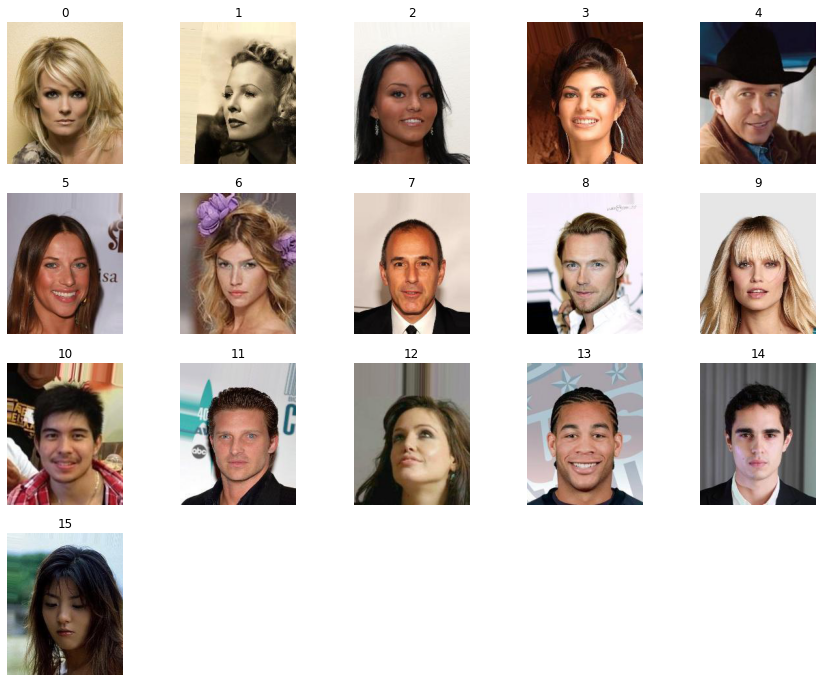

In [9]:
def display_images(images, cols=5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image) in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(i)

NUM_IMAGES = 16
# Extract each images individually for plot
batch_images = [im.numpy() for im in item['image']]
display_images(batch_images)